In [15]:
import torch
from torch.utils.data import DataLoader
from core_vq import ResidualVectorQuantization, VectorQuantization
import matplotlib.pyplot as plt

In [2]:
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, *size):
        self.data = torch.randn(size)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# Set hyperparameters
b = 32
d = 2 # dim=2 for easy visualization
t = 75
codebook_size = 1024
num_epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
rvq = ResidualVectorQuantization(num_quantizers=12, dim=d, codebook_size=codebook_size).to(device)   
vq = VectorQuantization(dim=d, codebook_size=codebook_size).to(device)
dataset = DummyDataset(b, d, t)
dataloader = DataLoader(dataset, batch_size=b, shuffle=True)

In [5]:
rvq_losses = []
vq_losses = []

for epoch in range(num_epochs):
    running_rvq_loss = 0.0
    running_vq_loss = 0.0
    for _, data in enumerate(dataloader):
        data = data.to(device)
        _, _, loss = vq(data)
        _, _, out_losses = rvq(data)
        running_vq_loss += loss.item()
        running_rvq_loss += out_losses.mean().item()
    
    vq_loss = running_vq_loss / len(dataloader)
    rvq_loss = running_rvq_loss / len(dataloader)
    vq_losses.append(vq_loss)
    rvq_losses.append(rvq_loss)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch} | VQ_loss: {vq_loss} | RVQ_loss: {rvq_loss}')     

Epoch 0 | VQ_loss: 0.0010637118248268962 | RVQ_loss: 9.337203664472327e-05
Epoch 100 | VQ_loss: 0.005551575217396021 | RVQ_loss: 0.0005006629507988691
Epoch 200 | VQ_loss: 0.004877184517681599 | RVQ_loss: 0.00043924496276304126
Epoch 300 | VQ_loss: 0.004593591205775738 | RVQ_loss: 0.0004111893940716982
Epoch 400 | VQ_loss: 0.0044022854417562485 | RVQ_loss: 0.00039559334982186556
Epoch 500 | VQ_loss: 0.004305684473365545 | RVQ_loss: 0.0003869968350045383
Epoch 600 | VQ_loss: 0.004234338644891977 | RVQ_loss: 0.000383569800760597
Epoch 700 | VQ_loss: 0.004205657169222832 | RVQ_loss: 0.00038132420741021633
Epoch 800 | VQ_loss: 0.004197280388325453 | RVQ_loss: 0.0003798570833168924
Epoch 900 | VQ_loss: 0.004186843987554312 | RVQ_loss: 0.00037892439286224544


Text(0, 0.5, 'Loss')

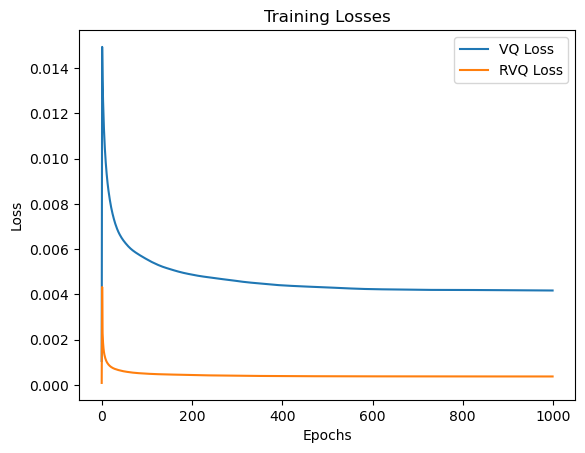

In [16]:
# Plot tjhe losses
plt.plot(vq_losses, label='VQ Loss')
plt.plot(rvq_losses, label='RVQ Loss')

plt.legend()
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [27]:
x = torch.randn(1, d, t).to(device) # sample random data
q_rvq = rvq.encode(x)
q_vq = vq.encode(x)

In [28]:
xhat_rvq = rvq.decode(q_rvq)
xhat_vq = vq.decode(q_vq)

In [29]:
x.shape, xhat_rvq.shape, xhat_vq.shape

(torch.Size([1, 2, 75]), torch.Size([1, 2, 75]), torch.Size([1, 2, 75]))

In [30]:
x = x[0].permute(1, 0).cpu().detach().numpy()
xhat_rvq = xhat_rvq[0].permute(1, 0).cpu().detach().numpy() 
xhat_vq = xhat_vq[0].permute(1, 0).cpu().detach().numpy()

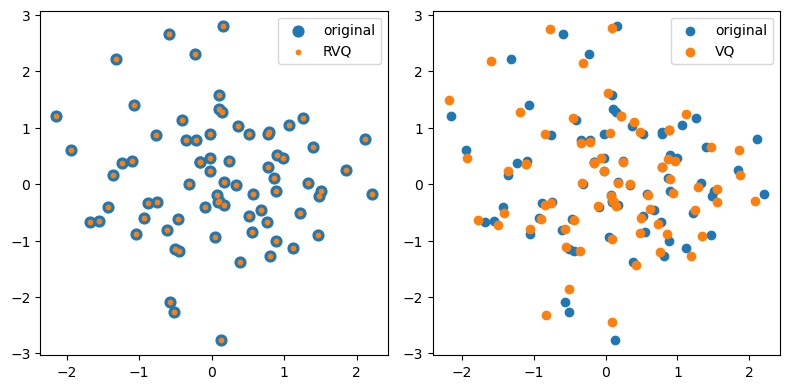

In [78]:
# Plot the original and reconstructed RVQ, VQ data
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x[:, 0], x[:, 1], label='original', s=60)
ax[0].scatter(x[:, 0], x[:, 1], label='RVQ', s=10)
ax[0].legend()

ax[1].scatter(x[:, 0], x[:, 1], label='original')
ax[1].scatter(xhat_vq[:, 0], xhat_vq[:, 1], label='VQ')
ax[1].legend()

plt.tight_layout()
plt.show()

PS. You can clearly see above that the ResidualVectorQuantization(RVQ) outperforms the VectorQuantization(VQ) in this scenario!